# Install the required libraries

In [5]:
!pip install neattext
!pip install fasttext

In [ ]:
#Unccomment and run if you don't have these libraries
# !pip uninstall tensorflow-io
# !pip uninstall tensorflow
# !pip install tensorflow==2.6.0
# !pip install tensorflow-io==0.21.0


In [ ]:
#Uncheck and run when error with the below library 
# !pip uninstall tensorflow-io -y

In [ ]:
#Uncheck and run when error with the below library 
# !pip uninstall tensorflow -y

In [ ]:
#To reinstall the libraries that were uninstalled
# !pip install tensorflow==2.12.0
# !pip install tensorflow-io==0.31.0

In [ ]:
!pip install transformers

# Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fasttext.util
import gensim
import tensorflow as tf
import neattext.functions as nfx
import pickle
import tensorflow_hub as hub
import tensorflow_text as text
import torch
import torch.nn as nn
import transformers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GlobalMaxPooling1D, Input, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel, AutoModel, BertTokenizerFast, TFRobertaModel, RobertaTokenizer
from transformers import TFDistilBertModel, DistilBertTokenizer
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix






#If it throws error, referesh the button by the Oupput where you see /Kaggle/working by your right side

# Data Loading and Splitting

In [4]:
# Load the dataset
data = pd.read_csv('/kaggle/input/suicide-detection/Suicide_Detection.csv')

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10) #I changed the seed from 10 to 42


# Data Exploration

In [6]:
# Display information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


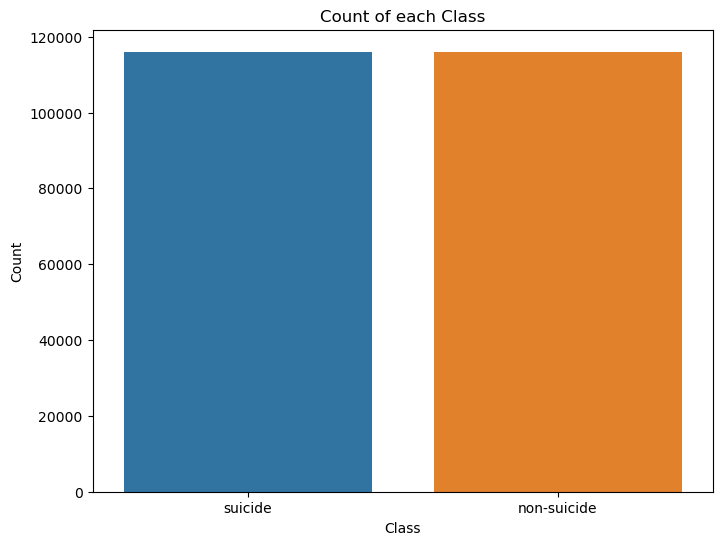

In [7]:

# Visualize the count of each class in the dataset

class_counts = data['class'].value_counts()

# Plot count of each category
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of each Class')
plt.show()



In [8]:
data['class'].value_counts()


suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [9]:
data['text']

0         Ex Wife Threatening SuicideRecently I left my ...
1         Am I weird I don't get affected by compliments...
2         Finally 2020 is almost over... So I can never ...
3                 i need helpjust help me im crying so hard
4         I’m so lostHello, my name is Adam (16) and I’v...
                                ...                        
232069    If you don't like rock then your not going to ...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty tea😏💦‼️ can som...
232072    The usual stuff you find hereI'm not posting t...
232073    I still haven't beaten the first boss in Hollo...
Name: text, Length: 232074, dtype: object

In [10]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

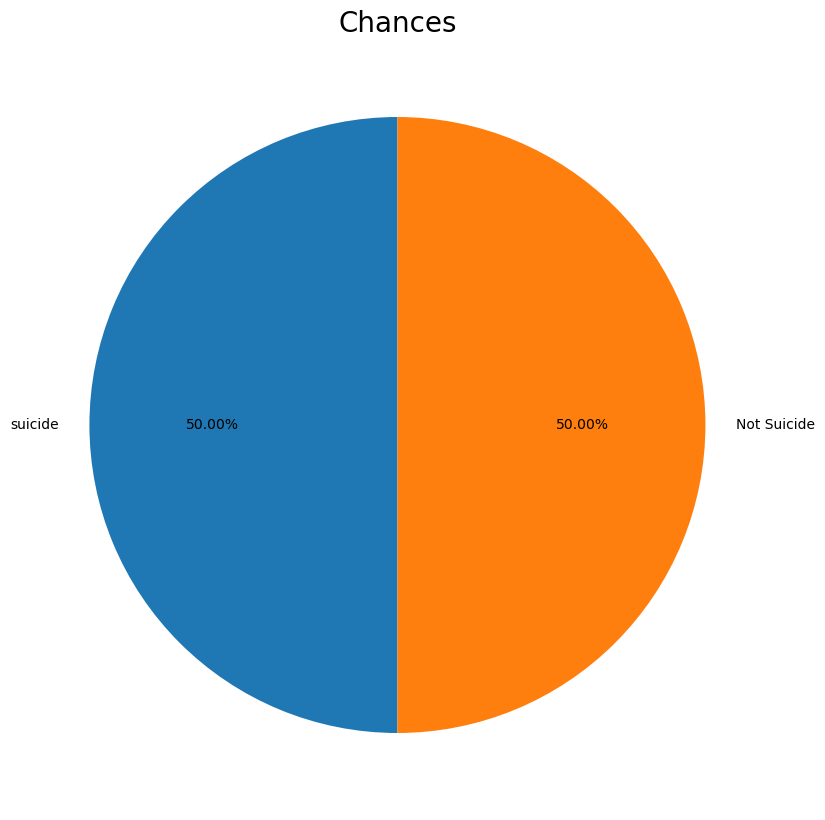

In [11]:
plt.figure(figsize=(12, 10))
plt.pie(train_data['class'].value_counts(), startangle=90, autopct='%0.2f%%', labels=['suicide', 'Not Suicide'])
plt.title('Chances', fontdict={'size': 20})
plt.show()

# Data Preprocessing

In [78]:
train_data_suicidal = train_data[train_data['class'] == "suicide"]
train_data_nonsuicidal = train_data[train_data['class'] == "non-suicide"]

In [80]:
# Clean the text data
def clean_text(text):
    text_length = []
    cleaned_text = []
    for sent in tqdm(text):
        sent = sent.lower()
        sent = nfx.remove_special_characters(sent)
        sent = nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text, text_length

cleaned_suicide_train_text, train_suicide_text_length = clean_text(train_data_suicidal.text)


100%|██████████| 116037/116037 [00:13<00:00, 8863.28it/s]


In [81]:
# Clean the text data
def clean_text(text):
    text_length = []
    cleaned_text = []
    for sent in tqdm(text):
        sent = sent.lower()
        sent = nfx.remove_special_characters(sent)
        sent = nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text, text_length

cleaned_nonsuicide_train_text, train_nonsuicide_text_length = clean_text(train_data_nonsuicidal.text)

100%|██████████| 116037/116037 [00:04<00:00, 24741.75it/s]


In [74]:
# Clean the text data
def clean_text(text):
    text_length = []
    cleaned_text = []
    for sent in tqdm(text):
        sent = sent.lower()
        sent = nfx.remove_special_characters(sent)
        sent = nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text, text_length

cleaned_train_text, train_text_length = clean_text(train_data.text)
cleaned_test_text, test_text_length = clean_text(test_data.text)


100%|██████████| 46415/46415 [00:03<00:00, 13053.51it/s]


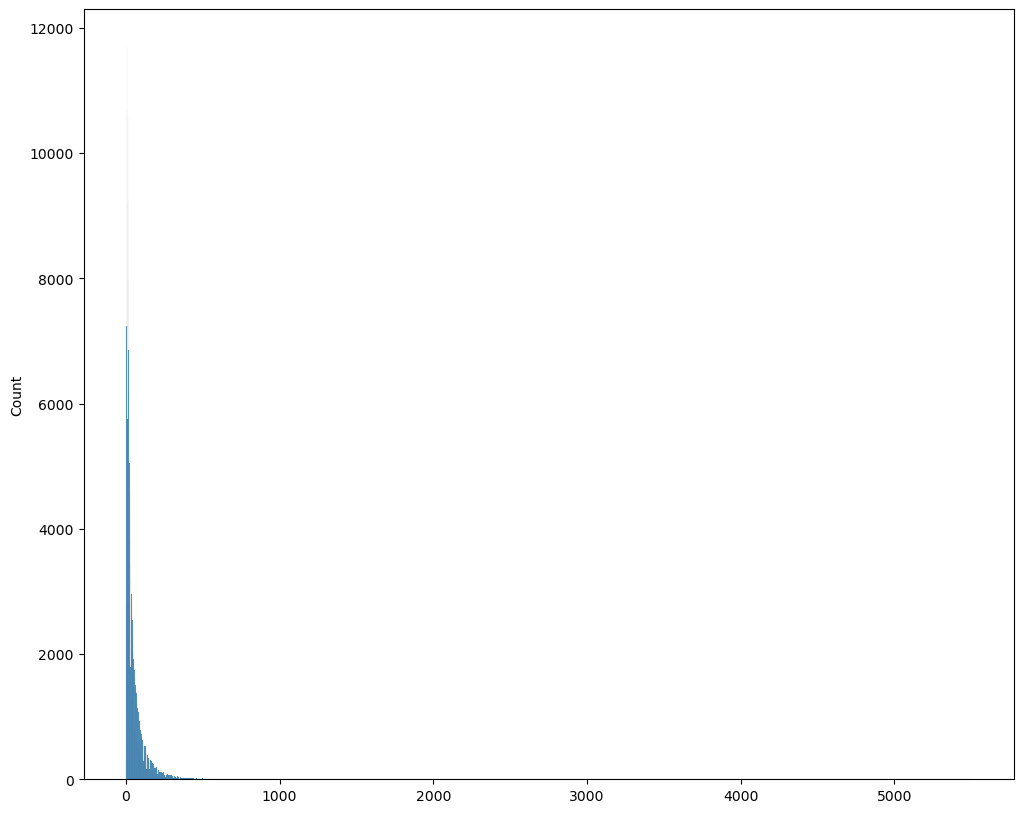

In [17]:
# Visualize the distribution of sentence lengths in the training data

plt.figure(figsize=(12, 10))
sns.histplot(train_text_length)
plt.show()

# Suicide Text

In [ ]:
tokenizer_nonsuicidal.word_counts.items()

# Word Frequency Bar Graph

In [91]:
word_freq_suicidal = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)

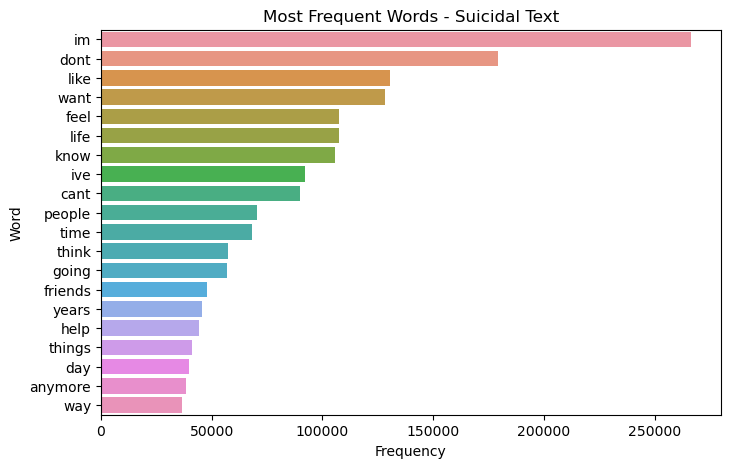

In [92]:
# Word Frequency Bar Graph
plt.figure(figsize=(8, 5))
sns.barplot(x='count',y='word',data=word_freq_suicidal.iloc[:20])
plt.title('Most Frequent Words - Suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Wordcloud

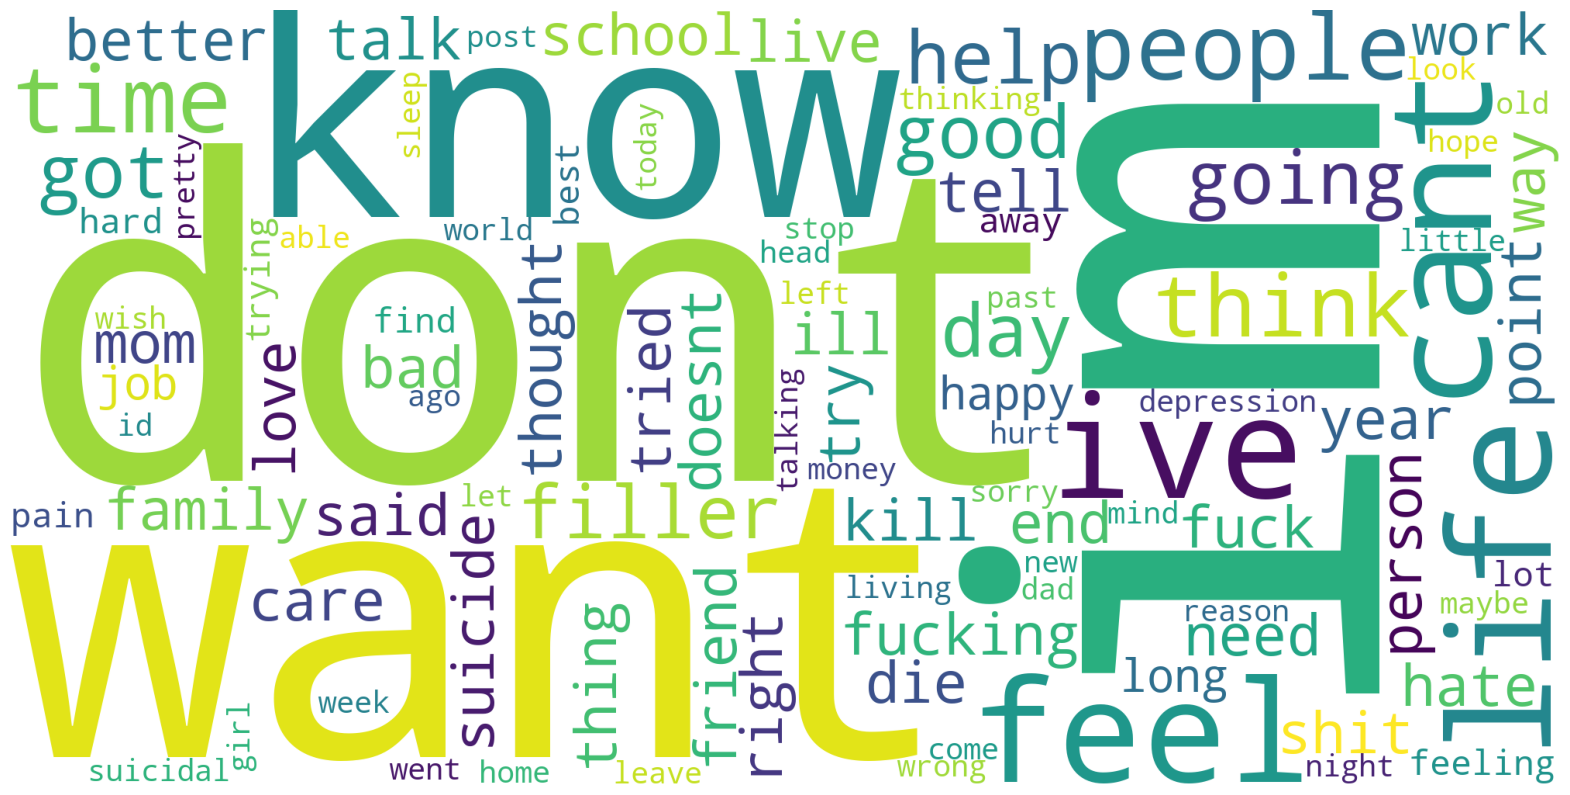

In [86]:
# Wordcloud 
feature_names=word_freq_suicidal['word'].values
wc=WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(8,5))
plt.axis('off')
plt.imshow(wc)
plt.show()

# Distribution of Text Length

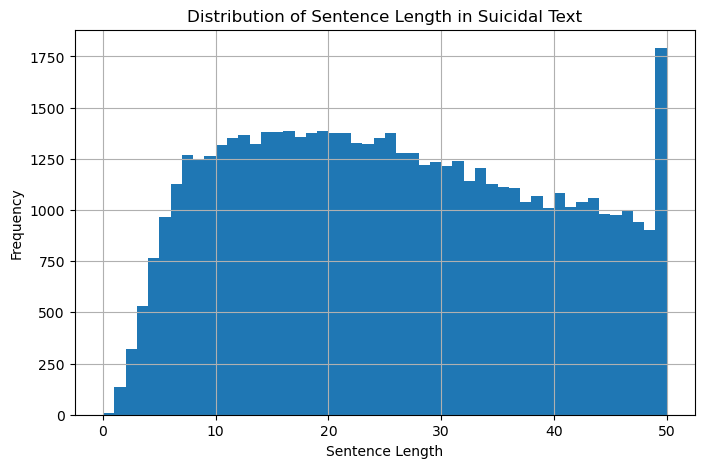

In [104]:
# Plot average text length
# ax = train_data_suicidal['length'].plot(kind='hist',title='Distribution of Text Length - Suicidal Text', figsize=(8,6))
# ax.set_xlabel("Number of Words")
# ax.set_ylabel("Count")
# plt.show()

# plt.figure(figsize=(5, 3))
# train_data_suicidal['length'].hist(bins=50, range=(0, 50))  # Set the range of x-axis to (0, 500)
# plt.xlabel('Sentence Length')
# plt.ylabel('Frequency')
# plt.title('Distribution of Text Length - Suicidal Text')
# plt.show()

# Create a DataFrame from the cleaned_train_text and train_text_length
train_suicide_data_length = pd.DataFrame({'Text': cleaned_suicide_train_text, 'Length': train_suicide_text_length})

# Plot the length of sentences
plt.figure(figsize=(8, 5))
train_suicide_data_length['Length'].hist(bins=50, range=(0, 50))  # Set the range of x-axis to (0, 500)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Length in Suicidal Text')
plt.show()


# Polarity Score Distribution

In [106]:
# Polarity score distribution
from textblob import TextBlob

def get_polarity(text):
  return TextBlob(text).sentiment.polarity
train_data_suicidal['Polarity'] = train_suicide_data_length['Text'].apply(get_polarity)

/tmp/ipykernel_28/1185024442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_suicidal['Polarity'] = train_suicide_data_length['Text'].apply(get_polarity)


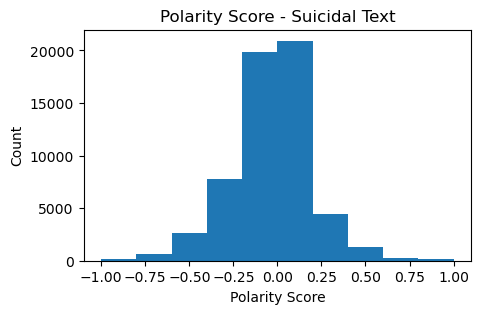

In [107]:
# Plot polarity score graph
ax = train_data_suicidal['Polarity'].plot(kind='hist', title='Polarity Score - Suicidal Text', figsize=(5,3))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

# Non-Suicide Text

In [55]:
tokenizer_nonsuicidal = Tokenizer()
tokenizer_nonsuicidal.fit_on_texts(train_data_nonsuicidal["text"])

In [56]:
tokenizer_nonsuicidal.word_counts.items()

odict_items([('am', 16571), ('i', 292133), ('weird', 3658), ("don't", 16460), ('get', 24842), ('affected', 157), ('by', 10208), ('compliments', 189), ('if', 36278), ("it's", 12597), ('coming', 1913), ('from', 15794), ('someone', 10552), ('know', 24775), ('irl', 690), ('but', 58162), ('feel', 14568), ('really', 18417), ('good', 12847), ('when', 19819), ('internet', 1412), ('strangers', 290), ('do', 36967), ('it', 93951), ('finally', 2666), ('2020', 1182), ('is', 70525), ('almost', 2758), ('over', 7273), ('so', 57649), ('can', 21132), ('never', 10047), ('hear', 2143), ('has', 11189), ('been', 13702), ('a', 159638), ('bad', 7238), ('year', 8201), ('ever', 6586), ('again', 5566), ('swear', 680), ('to', 187598), ('fucking', 9398), ('god', 2889), ('annoying', 1445), ('everyone', 6245), ('wants', 2262), ('be', 39085), ('edgy', 164), ('and', 190284), ('making', 3276), ('me', 75964), ('self', 2040), ('conscious', 151), ('like', 50524), ('stand', 732), ('out', 23579), ('draw', 573), ('yes', 3110

In [57]:
word_freq_nonsuicidal = pd.DataFrame(tokenizer_nonsuicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_nonsuicidal.head()

word   count
1     i  292133
49  and  190284
41   to  187598
60  the  168904
35    a  159638

# Word Frequency Bar Graph

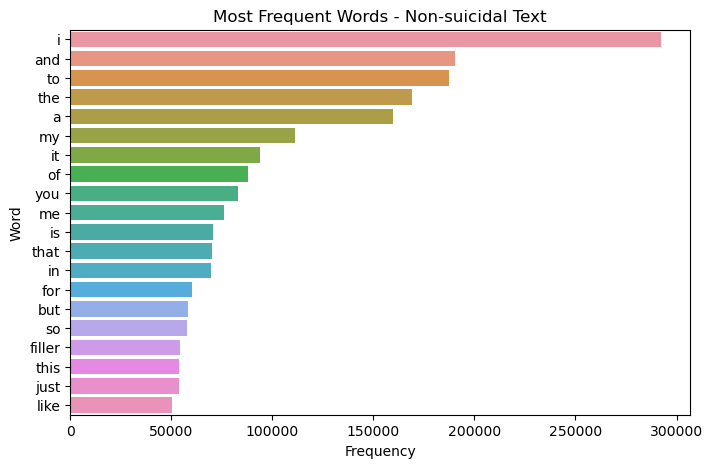

In [59]:
# Word Frequency Bar Graph
plt.figure(figsize=(8, 5))
sns.barplot(x='count', y='word', data=word_freq_nonsuicidal.iloc[:20])
plt.title('Most Frequent Words - Non-suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Wordcloud

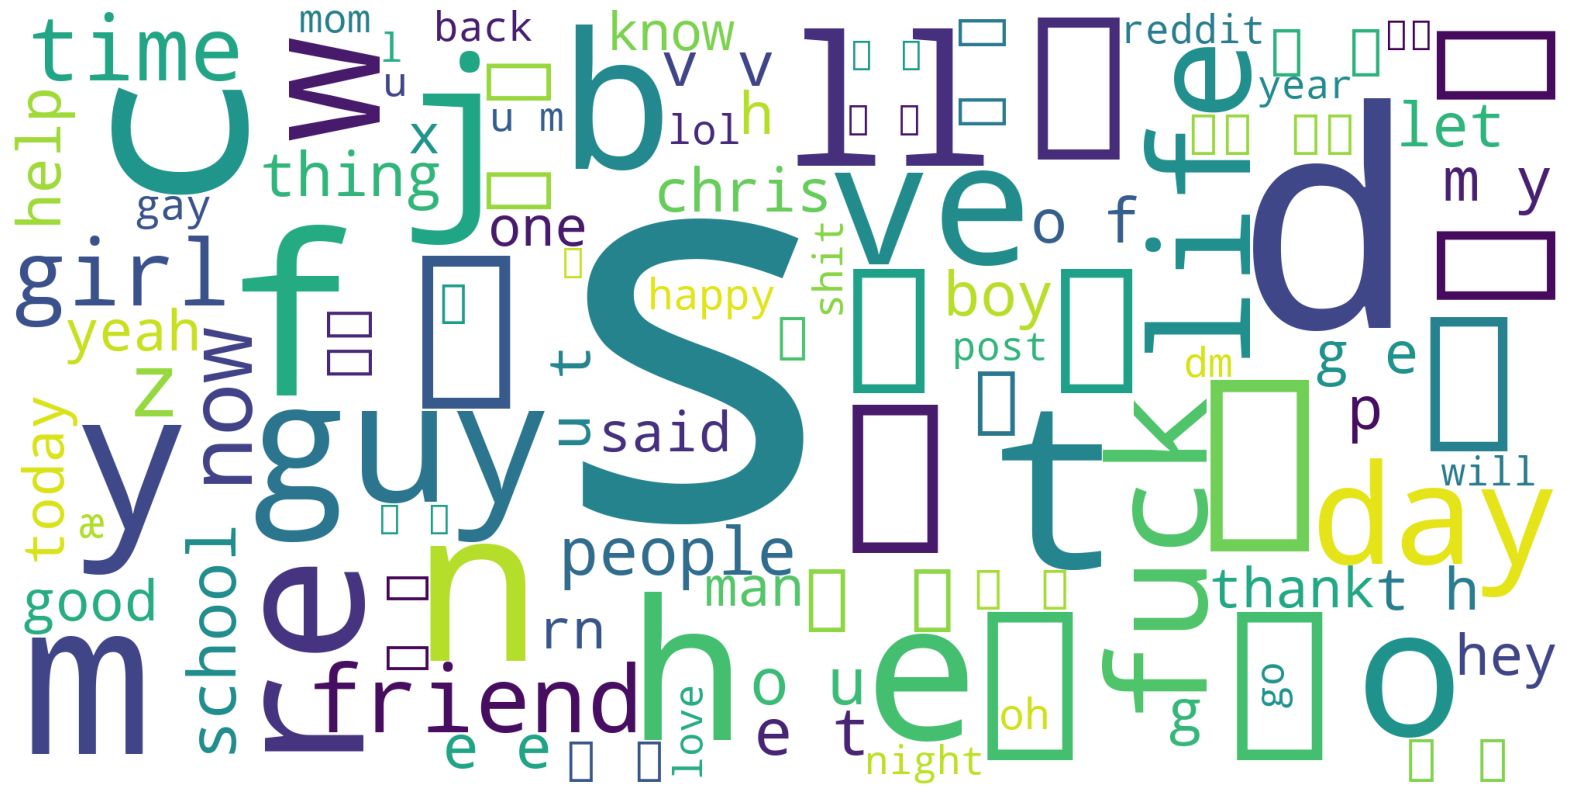

In [60]:
# Wordcloud  
feature_names_nonsuicidal = word_freq_nonsuicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_nonsuicidal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

# Distribution of Text Length

In [61]:
# Get average text length
train_data_nonsuicidal['text'] = train_data_nonsuicidal['text'].astype('str')
train_data_nonsuicidal['length'] = train_data_nonsuicidal['text'].apply(lambda x: len(x.split()))

/tmp/ipykernel_28/4112220707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['text'] = train_data_nonsuicidal['text'].astype('str')
/tmp/ipykernel_28/4112220707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['length'] = train_data_nonsuicidal['text'].apply(lambda x: len(x.split()))


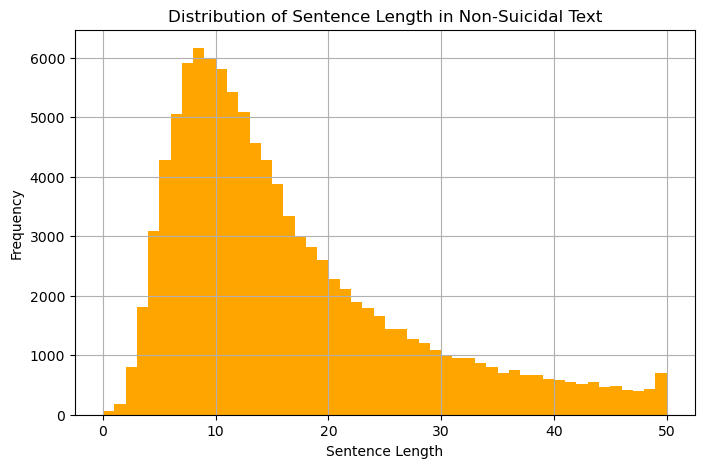

In [103]:
# Plot distribution of text length
# ax = train_data_nonsuicidal['length'].plot(kind='hist',title='Distribution of Text Length - Non-suicidal Text', color='orange', figsize=(8,6))
# ax.set_xlabel("Number of Words")
# ax.set_ylabel("Count")
# plt.show()

# plt.figure(figsize=(5, 3))
# train_data_nonsuicidal['length'].hist(bins=50, range=(0, 50), color='orange')  # Set the range of x-axis to (0, 500)
# plt.xlabel('Sentence Length')
# plt.ylabel('Frequency')
# plt.title('Distribution of Text Length - Non-Suicidal Text')
# plt.show()


# Create a DataFrame from the cleaned_train_text and train_text_length
train_nonsuicide_data_length = pd.DataFrame({'Text': cleaned_nonsuicide_train_text, 'Length': train_nonsuicide_text_length})

# Plot the length of sentences
plt.figure(figsize=(8, 5))
train_nonsuicide_data_length['Length'].hist(bins=50, range=(0, 50), color='orange')  # Set the range of x-axis to (0, 500)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Length in Non-Suicidal Text')
plt.show()

# Polarity Score Distribution

In [66]:
# Polarity score distribution
train_data_nonsuicidal['text'] = train_data_nonsuicidal['text'].astype('str')
train_data_nonsuicidal['Polarity'] = train_data_nonsuicidal['text'].apply(get_polarity)

/tmp/ipykernel_28/3677677760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['text'] = train_data_nonsuicidal['text'].astype('str')
/tmp/ipykernel_28/3677677760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['Polarity'] = train_data_nonsuicidal['text'].apply(get_polarity)


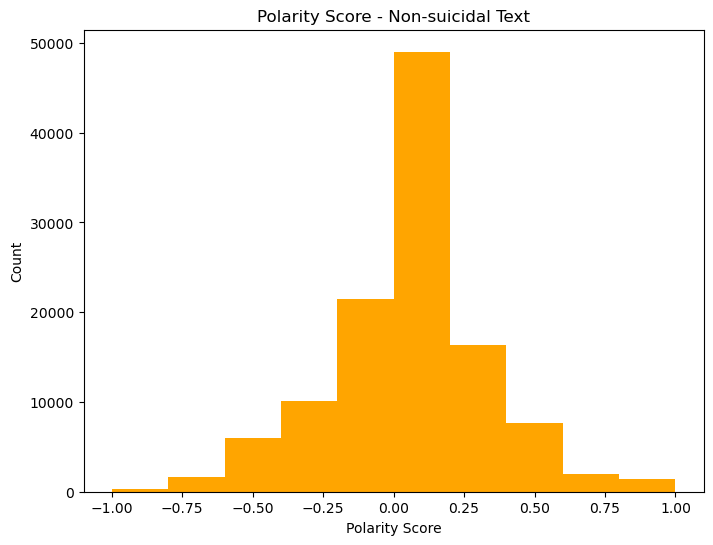

In [67]:
# Plot polarity score graph
ax = train_data_nonsuicidal['Polarity'].plot(kind='hist', title='Polarity Score - Non-suicidal Text', color="orange", figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

# Bigram

In [71]:
import itertools
nltk.download('stopwords')
stop_words = stopwords.words('english')

train_data_nonsuicidal['without_stopwords'] = train_data_suicidal['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_suicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

bigram_df

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_28/2432806291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['without_stopwords'] = train_data_suicidal['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


Bigram  Count
0      (I, want)  72549
1      (I, feel)  56971
2      (I, know)  51011
3     (I, can't)  41026
4   (feel, like)  39094
5     (I, think)  27613
6     (I, don’t)  26674
7     (I, could)  19430
8    (I, really)  18047
9       (me., I)  17930
10    (I, would)  16872
11     (like, I)  16426
12     (I, hate)  15710
13    (I, never)  15439
14     (know, I)  15411
15     (I, need)  15384
16      (I, get)  15025
17      (it., I)  13154
18    (I, can’t)  13127
19     (I, wish)  12193

<Axes: >

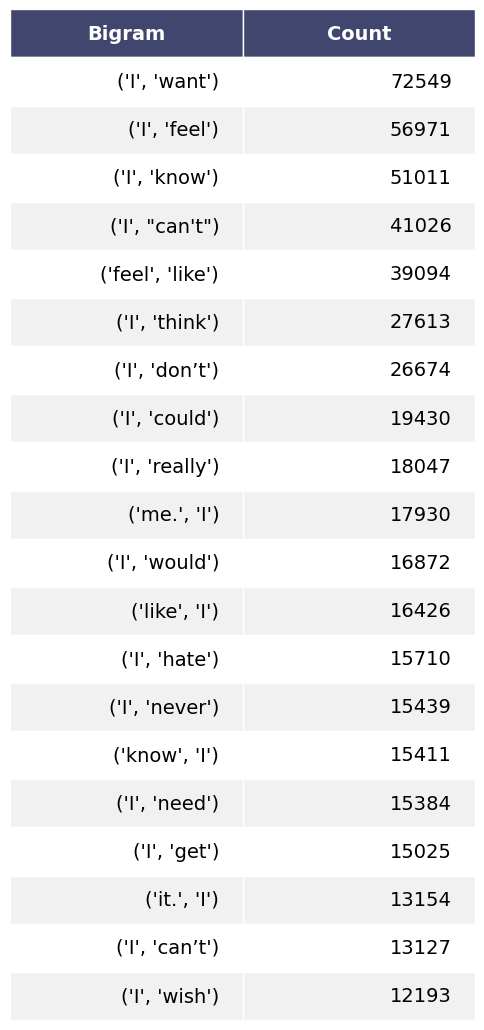

In [72]:

import six

#To make the table nicer
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(bigram_df, header_columns=0, col_width=3)

# Suicide And Nonsuicide Text

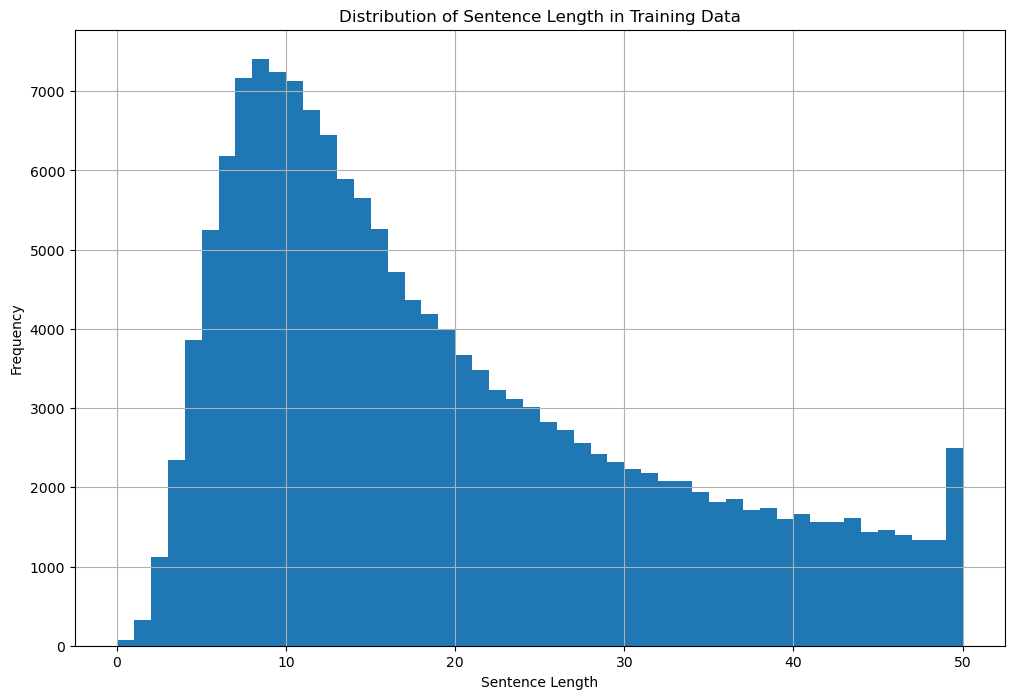

In [73]:
# Create a DataFrame from the cleaned_train_text and train_text_length
train_data_length = pd.DataFrame({'Text': cleaned_train_text, 'Length': train_text_length})

# Plot the length of sentences
plt.figure(figsize=(12, 8))
train_data_length['Length'].hist(bins=50, range=(0, 50))  # Set the range of x-axis to (0, 500)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Length in Training Data')
plt.show()


In [17]:
# Tokenize the text data

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(cleaned_train_text)


tokenizer = Tokenizer(num_words=30000)  # Set maximum features to 30,000. This we tried to increase accuracy
tokenizer.fit_on_texts(cleaned_train_text)

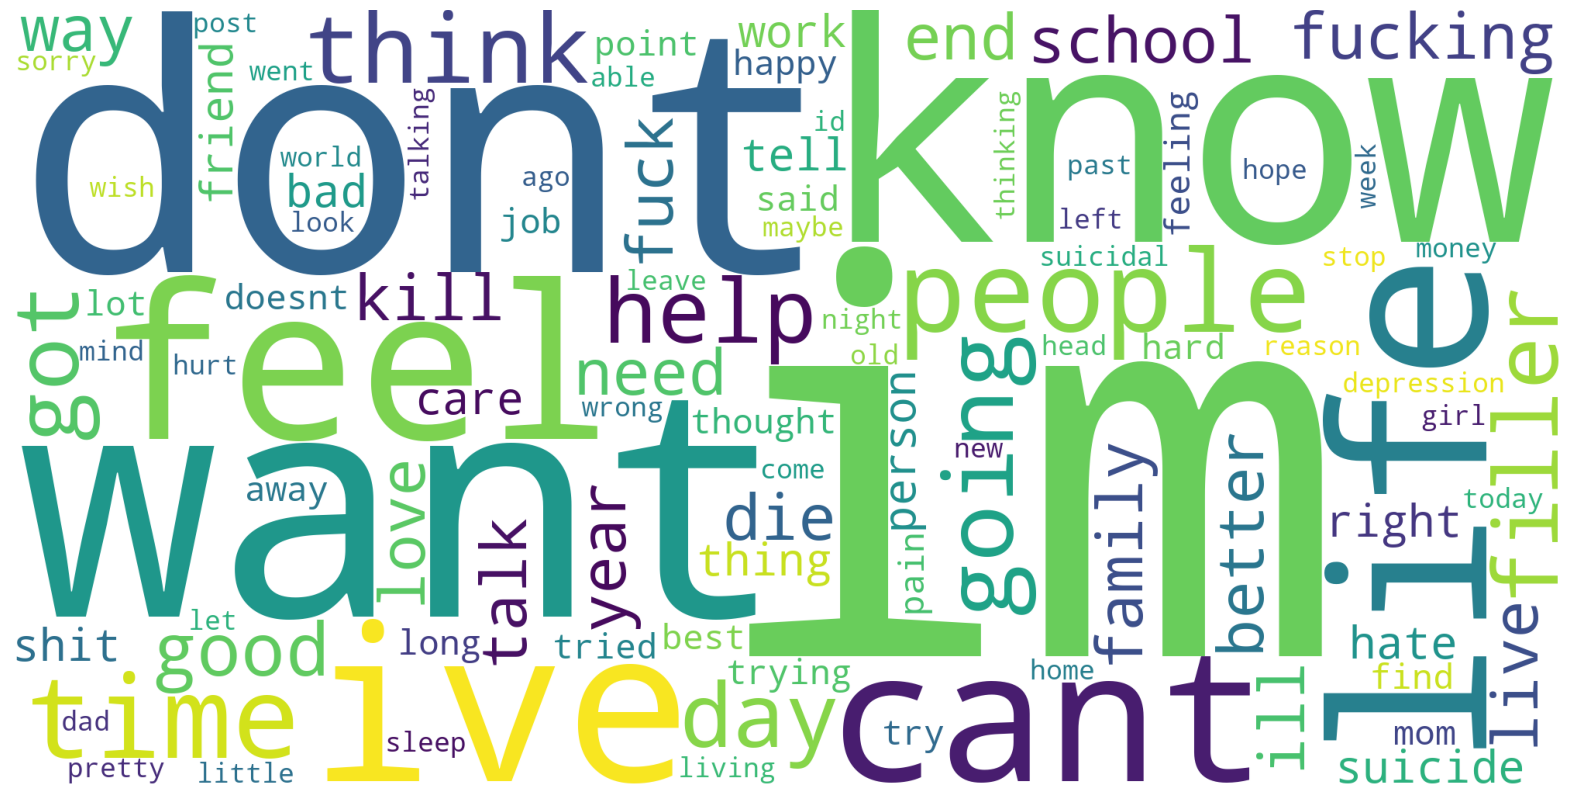

In [19]:
# Wordcloud 
from wordcloud import WordCloud

word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
feature_names_nonsuicidal = word_freq['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_nonsuicidal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

In [ ]:
# Plot average text length
ax = train_data_suicidal['length'].plot(kind='hist',title='Distribution of Text Length - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

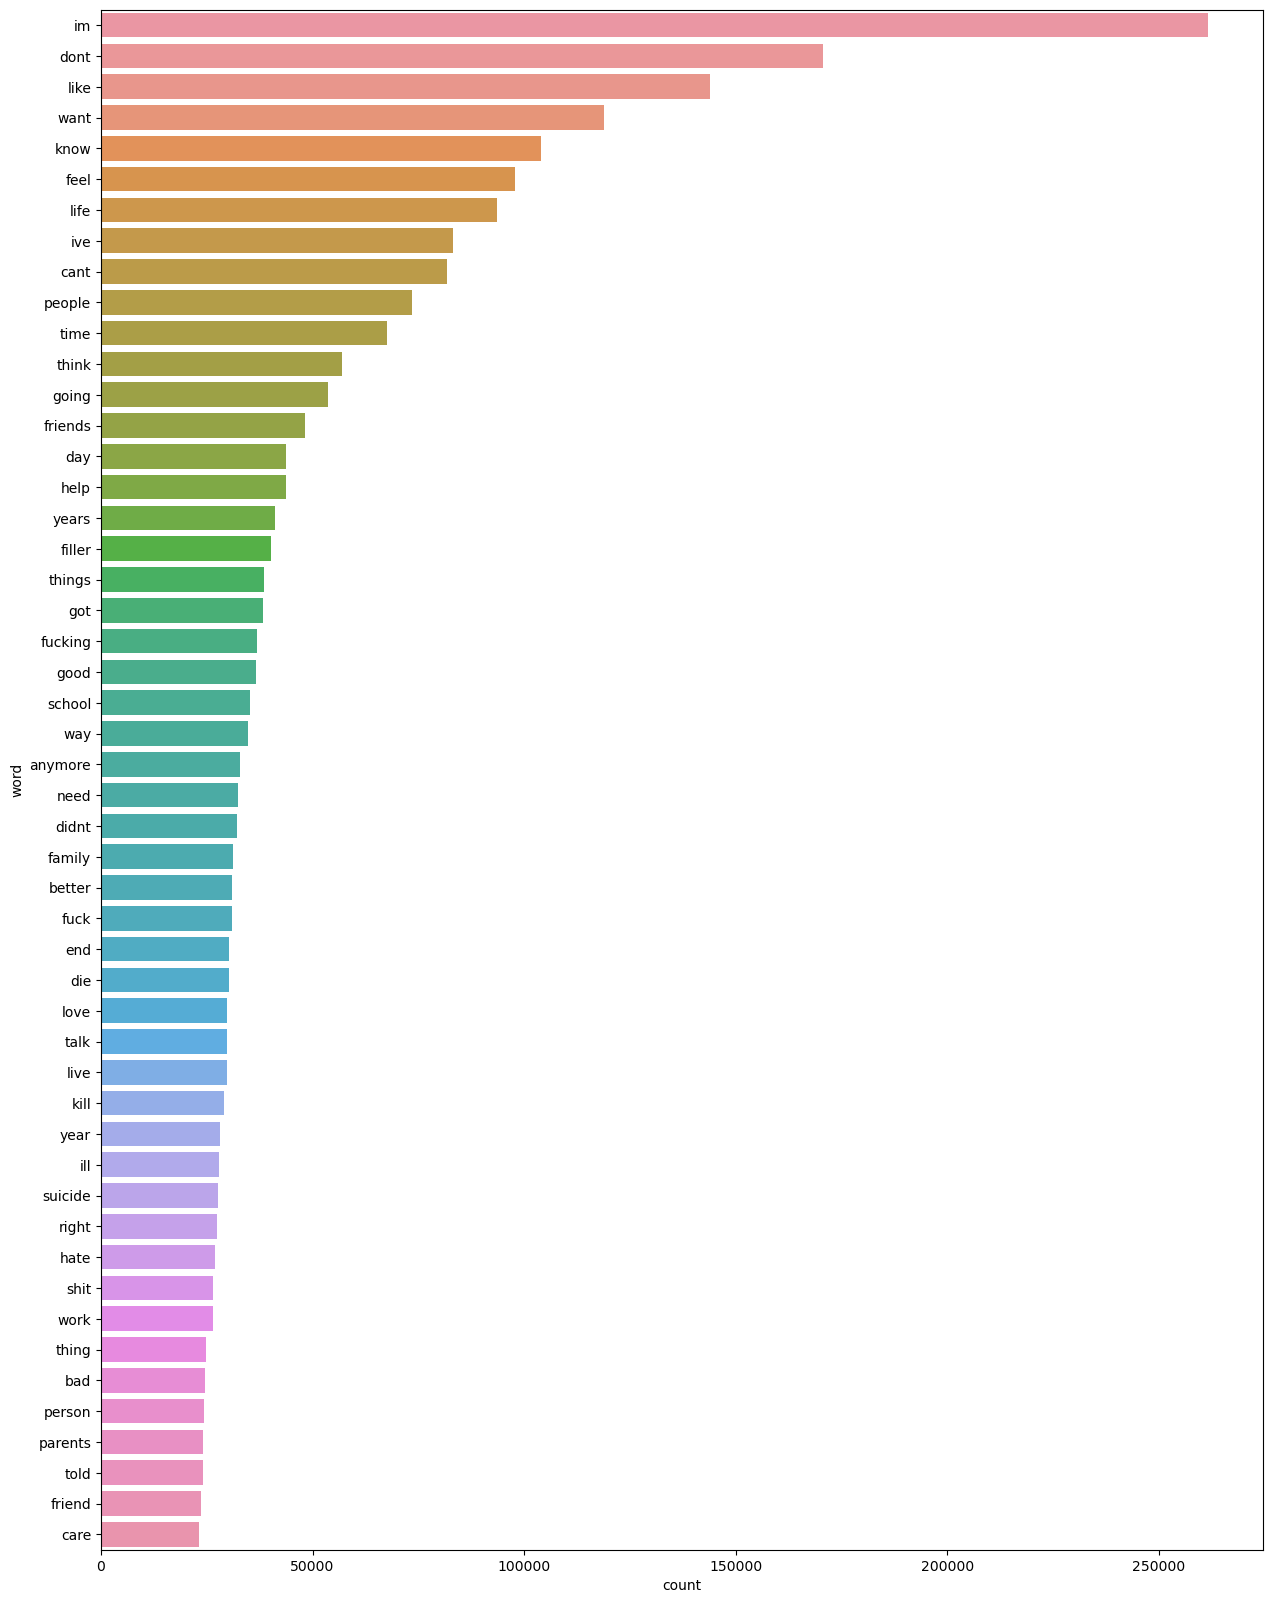

In [8]:
# Create word frequency dataframe
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

# Visualize the most frequent words
plt.figure(figsize=(15, 20))
sns.barplot(x='count', y='word', data=word_freq.iloc[:50])
plt.show()

In [7]:
# # Convert text to sequences and pad the sequences
# train_text_seq = tokenizer.texts_to_sequences(cleaned_train_text)
# train_text_pad = pad_sequences(train_text_seq, maxlen=100) # I changed the maxlen from 50 to 100

# test_text_seq = tokenizer.texts_to_sequences(cleaned_test_text)
# test_text_pad = pad_sequences(test_text_seq, maxlen=100) # I changed the maxlen from 50 to 100

# Convert text to sequences and pad the sequences
train_text_seq = tokenizer.texts_to_sequences(cleaned_train_text)
test_text_seq = tokenizer.texts_to_sequences(cleaned_test_text)



In [8]:
# Set the maximum length for each post
max_length = 430

# Pad the sequences to ensure they have the same length
train_text_pad = pad_sequences(train_text_seq, maxlen=max_length)
test_text_pad = pad_sequences(test_text_seq, maxlen=max_length)

In [9]:
# Encode the target labels
lbl_target = LabelEncoder()
train_output = lbl_target.fit_transform(train_data['class'])
test_output = lbl_target.transform(test_data['class'])

# Using Word2Vec embeddings
# 

In [ ]:
#Load word2Vec


word2vec_model_path = '/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin'
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [26]:
# Prepare embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]

In [60]:
# Build the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(64, 5, activation='relu'))  # Reduced number of filters
model.add(Conv1D(32, 5, activation='relu'))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))  # Reduced LSTM units
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))  # Reduced dense units
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
word2vec_model = model.summary()
word2vec_model

# Compile the model
optimizer = Adam(learning_rate=0.00001)#We changed from 0.0001 to 0.00001 changed back to 0.0001 then to 0.00001
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 5
history_word2vec = model.fit(train_text_pad, train_output, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 430, 300)          81560700  
                                                                 
 conv1d_20 (Conv1D)          (None, 426, 64)           96064     
                                                                 
 conv1d_21 (Conv1D)          (None, 422, 32)           10272     
                                                                 
 bidirectional_7 (Bidirectio  (None, 422, 128)         49664     
 nal)                                                            
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 32)               

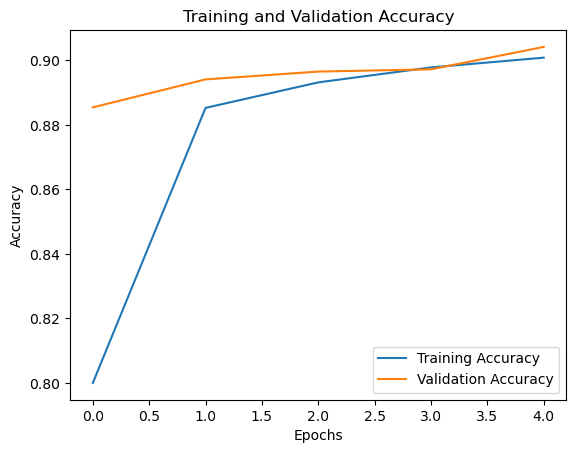

In [61]:
# Plot the training accuracy and validation accuracy
plt.plot(history_word2vec.history['accuracy'])
plt.plot(history_word2vec.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

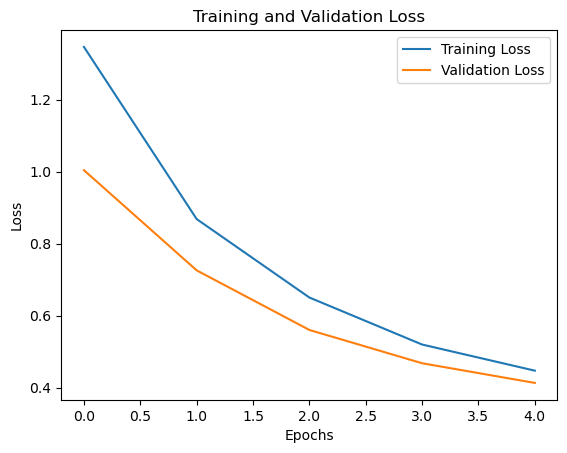

In [62]:
# Plot the training loss and validation loss
plt.plot(history_word2vec.history['loss'])
plt.plot(history_word2vec.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [63]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_text_pad, test_output, verbose=2)
print('Test Accuracy:', test_acc)

# Make predictions on the test set
word2vec_predictions = model.predict(test_text_pad)
word2vec_predictions = np.round(word2vec_predictions).flatten()

1451/1451 - 24s - loss: 0.4118 - accuracy: 0.9051 - 24s/epoch - 16ms/step
Test Accuracy: 0.9051384329795837
1451/1451 [==============================] - 23s 15ms/step


In [64]:
# Print classification report and confusion matrix
print("Classification Report For Model Built with Word2Vec:")
print(classification_report(test_output, word2vec_predictions))

print("Confusion Matrix:")
print(confusion_matrix(test_output, word2vec_predictions))

Classification Report For Model Built with Word2Vec:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     23209
           1       0.92      0.89      0.90     23206

    accuracy                           0.91     46415
   macro avg       0.91      0.91      0.91     46415
weighted avg       0.91      0.91      0.91     46415

Confusion Matrix:
[[21290  1919]
 [ 2484 20722]]


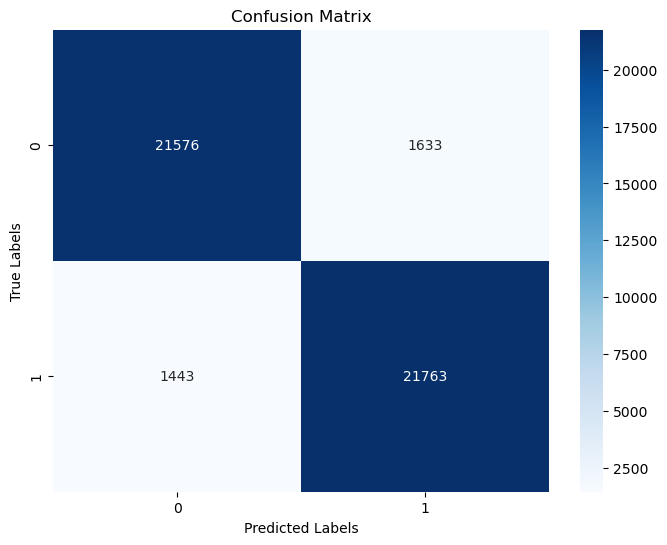

In [65]:
# Generate confusion matrix
cm = confusion_matrix(test_output, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Download FastText word embeddings

In [7]:
# Download fastText word embeddings
# fasttext.util.download_model('en', if_exists='ignore')
# ft = fasttext.load_model('cc.en.300.bin')

# ft = '/kaggle/input/fasttext-english/cc.en.300.bin'

ft = fasttext.load_model('/kaggle/input/fasttext-english/cc.en.300.bin')

In [1]:
# Prepare embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((30000, embedding_dim))  # Update the shape of the embedding matrix

NameError: name 'np' is not defined

In [14]:
# # Define the model architecture
# embedding_dim = 300
# embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# for word, idx in tokenizer.word_index.items():
#     embedding_vector = ft.get_word_vector(word)
#     if embedding_vector is not None:
#         embedding_matrix[idx] = embedding_vector

# Define the embedding matrix
# embedding_dim = 300
# embedding_matrix = np.zeros((30000, embedding_dim))
# # embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# for word, idx in tokenizer.word_index.items():
#     if idx < 30000:
#         embedding_vector = ft.get_word_vector(word)
#         if embedding_vector is not None:
#             embedding_matrix[idx] = embedding_vector  


for word, idx in tokenizer.word_index.items():
    if idx < 30000:  # Limit the vocabulary size to 30,000
        embedding_vector = ft.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [ ]:
# # Define early stopping and reduce learning rate callbacks
# early_stop = EarlyStopping(monitor='val_loss', patience=5) #It was 5 before, I changed it to 10, then 4. Changed to monitor... and patience
# reducelr = ReduceLROnPlateau(factor=0.1, patience=3)

# Build the model

In [15]:
# model = Sequential()
# # model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length,
# #                     trainable=False)) #I changed the input_length from 50 to 100
# model.add(Embedding(30000, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # 1D Convolutional layer. This wasn't there before. L1 and L2 together but removed L1
# model.add(Dropout(0.2))#Dropout 30% of the neurons. This so solve overfitting. This wasn't there before. Increased to 30, decrease to 20
# model.add(MaxPooling1D(5))  # MaxPooling layer. This wasn't there before
# model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))) #L1 and L2 together but removed L1
# model.add(Dropout(0.4))#Dropout of the neurons. It was increased from 20% to 30% to 40%, decrease to 30%. This so solve overfitting
# model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))) #Added to increase the complexity of the model to deal with overfitting
# model.add(Dropout(0.2)) #Added to increase the complexity of the model to deal with overfitting
# model.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))) #L1 and L2 together but removed L1
# model.add(Dropout(0.2))#Dropout 20% of the neurons. This so solve overfitting. Increased to 50%
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # Train the model
# history = model.fit(train_text_pad, train_output, epochs=40, batch_size=32, validation_split=0.1,
#                     callbacks=[early_stop, reducelr]) #Epoch was 5, validation was 10%. Epoch was increased to 30 after setting the monitor



# model = Sequential()
# model.add(Embedding(30000, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# model = Sequential()
# model.add(Embedding(30000, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Conv1D(64, 7, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust the learning rate
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # Train the model
# history = model.fit(train_text_pad, train_output, epochs=20, batch_size=32, validation_split=0.1,
#                     callbacks=[EarlyStopping(patience=3), ReduceLROnPlateau(patience=1)])



# Build the model
model = Sequential()
model.add(Embedding(30000, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
fastText_model = model.summary()
fastText_model

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Set the learning rate to 0.0001. Increasing the learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 5
history_fastText = model.fit(train_text_pad, train_output, batch_size=batch_size, epochs=epochs,
                    validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 430, 300)          9000000   
                                                                 
 conv1d (Conv1D)             (None, 426, 128)          192128    
                                                                 
 conv1d_1 (Conv1D)           (None, 422, 64)           41024     
                                                                 
 conv1d_2 (Conv1D)           (None, 418, 32)           10272     
                                                                 
 bidirectional (Bidirectiona  (None, 418, 256)         164864    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                         

# Train and Validation Accuracy Plot

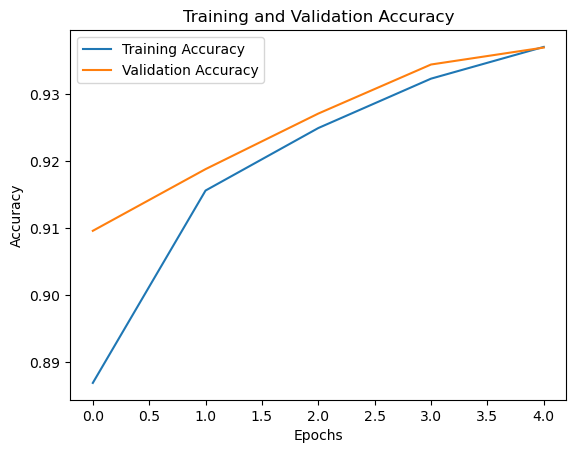

In [16]:
# Plot the training accuracy and validation accuracy
plt.plot(history_fastText.history['accuracy'])
plt.plot(history_fastText.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

# Train and Validation Loss Plot

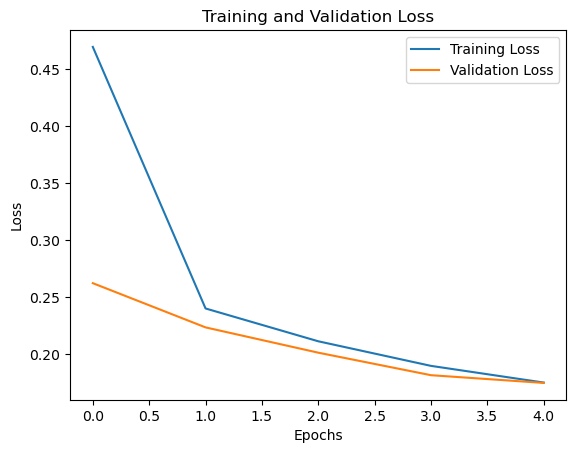

In [17]:
# Plot the training loss and validation loss
plt.plot(history_fastText.history['loss'])
plt.plot(history_fastText.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

# Model Evaluation

In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_text_pad, test_output, verbose=2)
print('Test Accuracy:', test_acc)

1451/1451 - 30s - loss: 0.1819 - accuracy: 0.9329 - 30s/epoch - 21ms/step
Test Accuracy: 0.9329311847686768


In [19]:
# Make predictions on the test set
fastText_predictions = model.predict(test_text_pad)
fastText_predictions = np.round(fastText_predictions).flatten()

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(test_output, fastText_predictions))

print("Confusion Matrix:")
print(confusion_matrix(test_output, fastText_predictions))


1451/1451 [==============================] - 30s 20ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     23209
           1       0.94      0.93      0.93     23206

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

Confusion Matrix:
[[21834  1375]
 [ 1738 21468]]


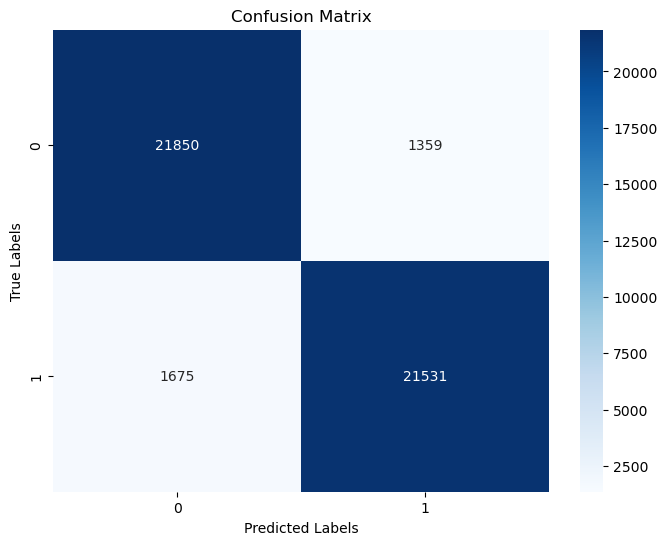

In [21]:
# Generate confusion matrix
cm = confusion_matrix(test_output, fastText_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Building Model Using GloVe

**Load the GloVe embeddings file**

In [6]:
with open('/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

**Prepare embedding matrix**

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        embedding_vector = glove_embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

**Build the model**

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

#Print the model summary
glove_model = model.summary()
glove_model

#Compile the model
optimizer = Adam(learning_rate=0.0001) # Set the learning rate to 0.001
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#Train the model
batch_size = 64
epochs = 5
history_glove = model.fit(train_text_pad, train_output, batch_size=batch_size, epochs=epochs,
validation_split=0.1)

In [ ]:
# Plot the training loss and validation loss
plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(history_glove.history['accuracy'])
plt.plot(history_glove.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

**Evaluate the model**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_text_pad, test_output)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

In [ ]:
# Predict on test data
glove_predictions = model.predict(test_text_pad)
glove_predictions = (glove_predictions > 0.5).astype(int)

In [ ]:
# Print classification report
print('Classification Report:')
print(classification_report(test_output, glove_predictions))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(test_output, glove_predictions))

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(test_output, glove_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Second Experience with FastText

The code splits the Suicide_Detection.csv dataset into 90% for training (train_data), 5% for validation (suicide_val_data), and 5% for testing (suicide_test_data). Similarly, the cease.csv dataset is split into 50% for validation (cease_val_data) and 50% for testing (cease_test_data). Then, the validation datasets from both sources are combined into val_data, and the testing datasets are combined into test_data.

In [7]:
!pip install -qqq unidecode contractions pyspellchecker wordninja symspellpy

In [8]:
import os
import pandas as pd
import numpy as np
import spacy
import unidecode
import contractions as contract
import re
import wordninja
import collections
import pkg_resources
from spellchecker import SpellChecker 
from symspellpy import SymSpell, Verbosity

In [6]:
# # Load the cease.csv dataset
# cease_data = pd.read_csv('/kaggle/input/cares-cease-v20/CARES-CEASE-v2.0 - CARES-CEASE-v2.0.csv')
# train_data = data

In [10]:
# Load dataset
cease_data = pd.read_csv('/kaggle/input/cares-cease-v20/CARES-CEASE-v2.0 - CARES-CEASE-v2.0.csv', index_col=0)
cease_data.reset_index(drop=True, inplace=True)
cease_data.head()

text        class
0  I am going to commit suicide and nobody is res...      suicide
1                            Live a little everyday.  non-suicide
2             I did have dreams, just like everyone.      suicide
3                        But now, it?s pretty empty.      suicide
4  All this positivity, the constant smiling, tel...      suicide

In [11]:
# Defining methods

nlp = spacy.load("en_core_web_sm") 
vocab = collections.Counter()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
"symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Spell Check using Symspell
def fix_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    correctedtext = suggestions[0].term # get the first suggestion, otherwise returns original text if nothing is corrected 
    return correctedtext 

# Remove some important words from stopwords list 
deselect_stop_words = ['no', 'not']
    
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

# Remove extra whitespaces from text
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

# Remove accented characters from text, e.g. café
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

# Remove URL 
def remove_url(text):
    return re.sub(r'http\S+', '', text)

# Removing symbols and digits
def remove_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

# Removing special characters
def remove_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

# Fix word lengthening (characters are wrongly repeated)
def fix_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def text_preprocessing(text, accented_chars=True, contractions=True, convert_num=True, 
                       extra_whitespace=True, lemmatization=True, lowercase=True, 
                       url=True, symbols_digits=True, special_chars=True, 
                       stop_words=True, lengthening=True, spelling=True):
    """preprocess text with default option set to true for all steps"""
    if accented_chars == True: # remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: # expand contractions
        text = contract.fix(text)
    if lowercase == True: # convert all characters to lowercase
        text = text.lower()
    if url == True: # remove URLs before removing symbols 
        text = remove_url(text)
    if symbols_digits == True: # remove symbols and digits
        text = remove_symbols_digits(text)
    if special_chars == True: # remove special characters
        text = remove_special(text)
    if extra_whitespace == True: # remove extra whitespaces
        text = remove_whitespace(text)
    if lengthening == True: # fix word lengthening
        text = fix_lengthening(text)
    if spelling == True: # fix spelling
        text = fix_spelling(text)

    doc = nlp(text) # tokenise text

    clean_text = []

    # return text
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # exclude number words
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            flag = False
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return " ".join(clean_text)

In [12]:
# Test functions on a subset of 20 rows
cease_data['cleaned_text'] = cease_data['text'][:20].apply(lambda row: text_preprocessing(row))
cease_data[:20]

text        class  \
0   I am going to commit suicide and nobody is res...      suicide   
1                             Live a little everyday.  non-suicide   
2              I did have dreams, just like everyone.      suicide   
3                         But now, it?s pretty empty.      suicide   
4   All this positivity, the constant smiling, tel...      suicide   
5   I never thought I would end up letting all of ...      suicide   
6                                     Do not miss me.      suicide   
7                  I dont deserve it I am not worthy.      suicide   
8   Just know that I love you all back just the wa...  non-suicide   
9   And also I am not doing this because I am sad ...      suicide   
10    I don?t have a job probably I wouldn?t get one.      suicide   
11                              No one hires a loser.      suicide   
12            It?s amazing to look at my grade sheet.  non-suicide   
13  A few more letter and it?ll look like an alpha...      suicide   
14             Thank you for being the best parents..  non-suicide   
15        I am sorry I turned out to be such a waste.      suicide   
16  I?ll make a good specimen cadaver to the futur...  non-suicide   
17  Ending my life: These 20 years of my life has ...      suicide   
18             I don?t find life interesting anymore.      suicide   
19           I just want to put an end to everything.      suicide   

                                     cleaned_text  
0             go commit suicide responsible death  
1                            live little everyday  
2                                      dream like  
3                                          pretty  
4     positivity constant smiling tell people not  
5                                   think end let  
6                                        not miss  
7                          not deserve not worthy  
8                      know love way friend right  
9                                         not sad  
10                               don job probably  
11                                  no hire loser  
12                       amazing look grade sheet  
13                letter look like alphabet chart  
14                              thank good parent  
15                               sorry turn waste  
16  ill good speciman cadaver future doctor india  
17                       end life year life teach  
18              don find life interesting anymore  
19                                       want end

In [13]:
# Apply preprocessing to all data
cease_data['cleaned_text'] = cease_data['text'].apply(lambda row: text_preprocessing(row))

In [ ]:
# Export cleaned dataset
df.to_csv('Data/suicide_detection_full_cleaned.csv', index=False)

In [21]:
# cease_data.head(5)

Unnamed: 0                                               text        class
0           1  I am going to commit suicide and nobody is res...      suicide
1           2                            Live a little everyday.  non-suicide
2           3             I did have dreams, just like everyone.      suicide
3           4                        But now, it?s pretty empty.      suicide
4           5  All this positivity, the constant smiling, tel...      suicide

In [22]:
cease_data['class'].value_counts()

suicide        4085
non-suicide     847
Name: class, dtype: int64

In [23]:
cease_non_suicide = cease_data[cease_data['class']=='non-suicide']
cease_non_suicide.shape

(847, 3)

In [24]:
cease_suicide = cease_data[cease_data['class']=='suicide']
cease_suicide.shape

(4085, 3)

In [25]:
cease_downsampled = cease_suicide.sample(cease_non_suicide.shape[0], random_state=42)  # Replace 42 with your desired random state
cease_downsampled

Unnamed: 0                                               text    class
761          762          I guess it was opposition with the world.  suicide
948          949  Aruna nad Gopal Goyal are liars, cheaters and ...  suicide
2637        2638  i have been practicing law in this state for t...  suicide
1264        1265                        Where is the dignity there?  suicide
3182        3183  some place that hope runs out because everybod...  suicide
...          ...                                                ...      ...
2206        2207  But now finally, in these last couple weeks, t...  suicide
4044        4045  that they did not have to watch over me, that ...  suicide
4088        4089              papa i only see sadness in your face.  suicide
3510        3511  grades so what and then i will work and people...  suicide
2264        2265  I messed up once and took someone on a date bu...  suicide

[847 rows x 3 columns]

In [26]:
cease_balanced = pd.concat([cease_non_suicide,cease_downsampled])
cease_balanced.shape

(1694, 3)

In [27]:
cease_balanced['class'].value_counts()

non-suicide    847
suicide        847
Name: class, dtype: int64

In [28]:
# Split the Suicide_Detection.csv dataset
# train_data, suicide_val_test_data = train_test_split(data, test_size=0.1, random_state=10)


val_data, test_data = train_test_split(cease_balanced, test_size=0.5, random_state=10)



In [29]:
cease_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1694 entries, 1 to 2264
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1694 non-null   int64 
 1   text        1694 non-null   object
 2   class       1694 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.9+ KB


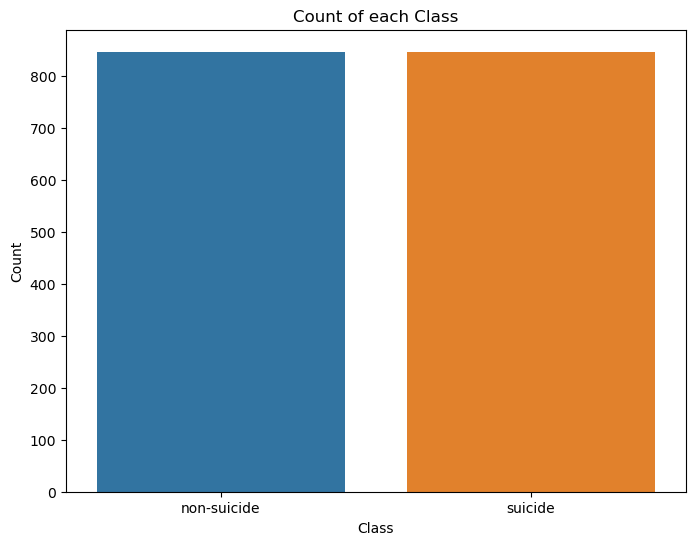

In [30]:
class_counts = cease_balanced['class'].value_counts()

# Plot count of each category
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of each Class')
plt.show()


In [31]:
cease_balanced['class'].value_counts().index.values

array(['non-suicide', 'suicide'], dtype=object)

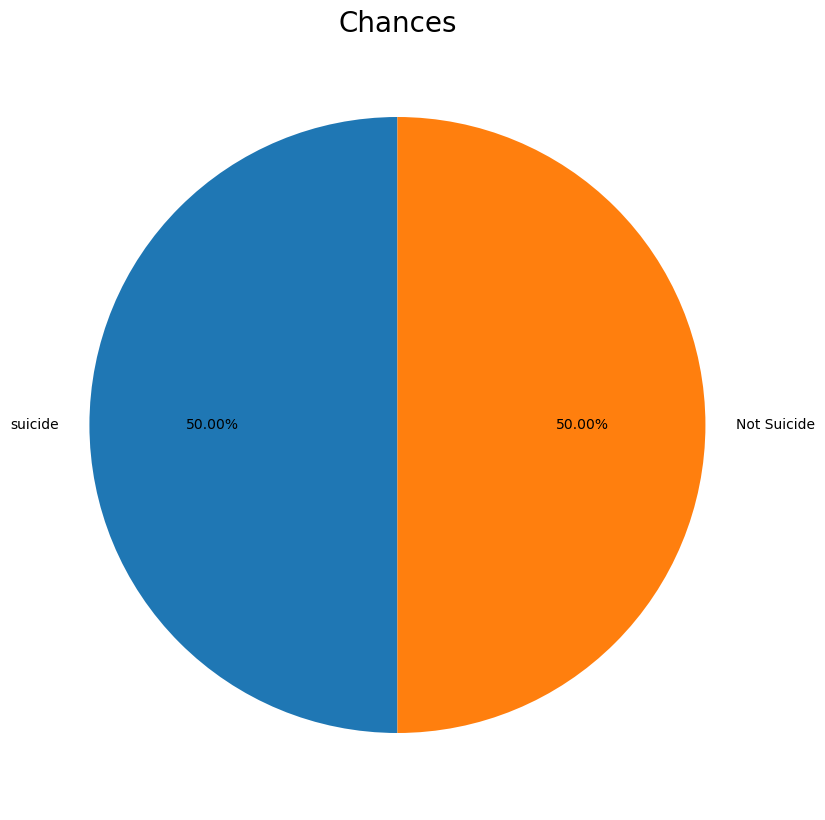

In [32]:
plt.figure(figsize=(12, 10))
plt.pie(train_data['class'].value_counts(), startangle=90, autopct='%0.2f%%', labels=['suicide', 'Not Suicide'])
plt.title('Chances', fontdict={'size': 20})
plt.show()

In [33]:
def clean_text(text):
    text_length = []
    cleaned_text = []
    for sent in tqdm(text):
        sent = sent.lower()
        sent = nfx.remove_special_characters(sent)
        sent = nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text, text_length

cleaned_train_text, train_text_length = clean_text(train_data.text)
cleaned_val_text, val_text_length = clean_text(val_data.text)
cleaned_test_text, test_text_length = clean_text(test_data.text)

100%|██████████| 847/847 [00:00<00:00, 73065.19it/s]


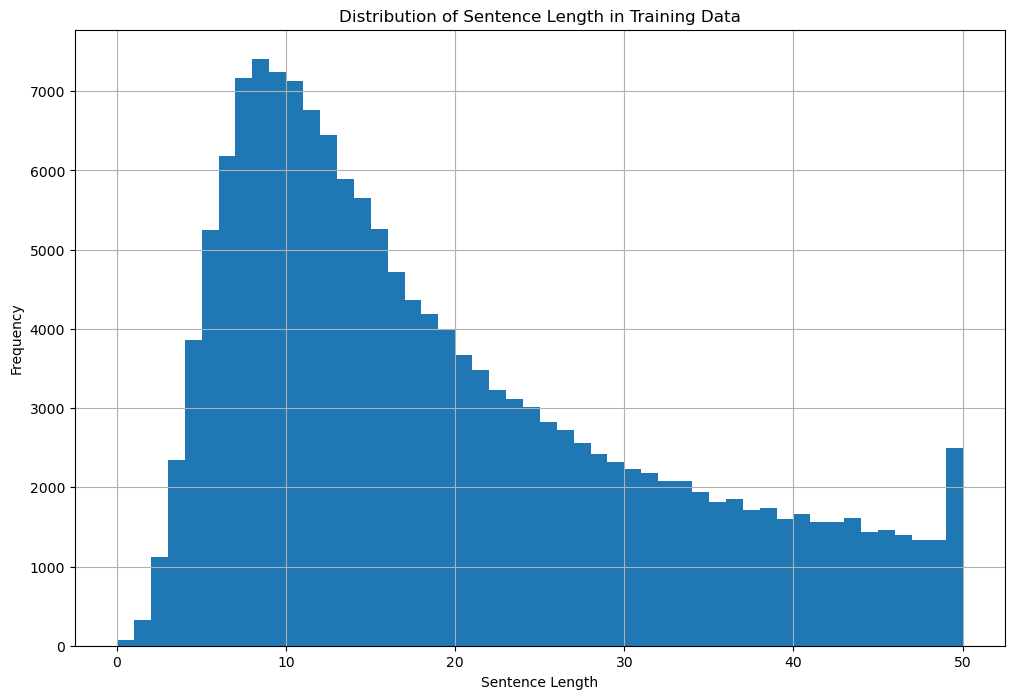

In [34]:
# Create a DataFrame from the cleaned_train_text and train_text_length
train_data_length = pd.DataFrame({'Text': cleaned_train_text, 'Length': train_text_length})

# Plot the length of sentences
plt.figure(figsize=(12, 8))
train_data_length['Length'].hist(bins=50, range=(0, 50))  # Set the range of x-axis to (0, 500)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Length in Training Data')
plt.show()

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

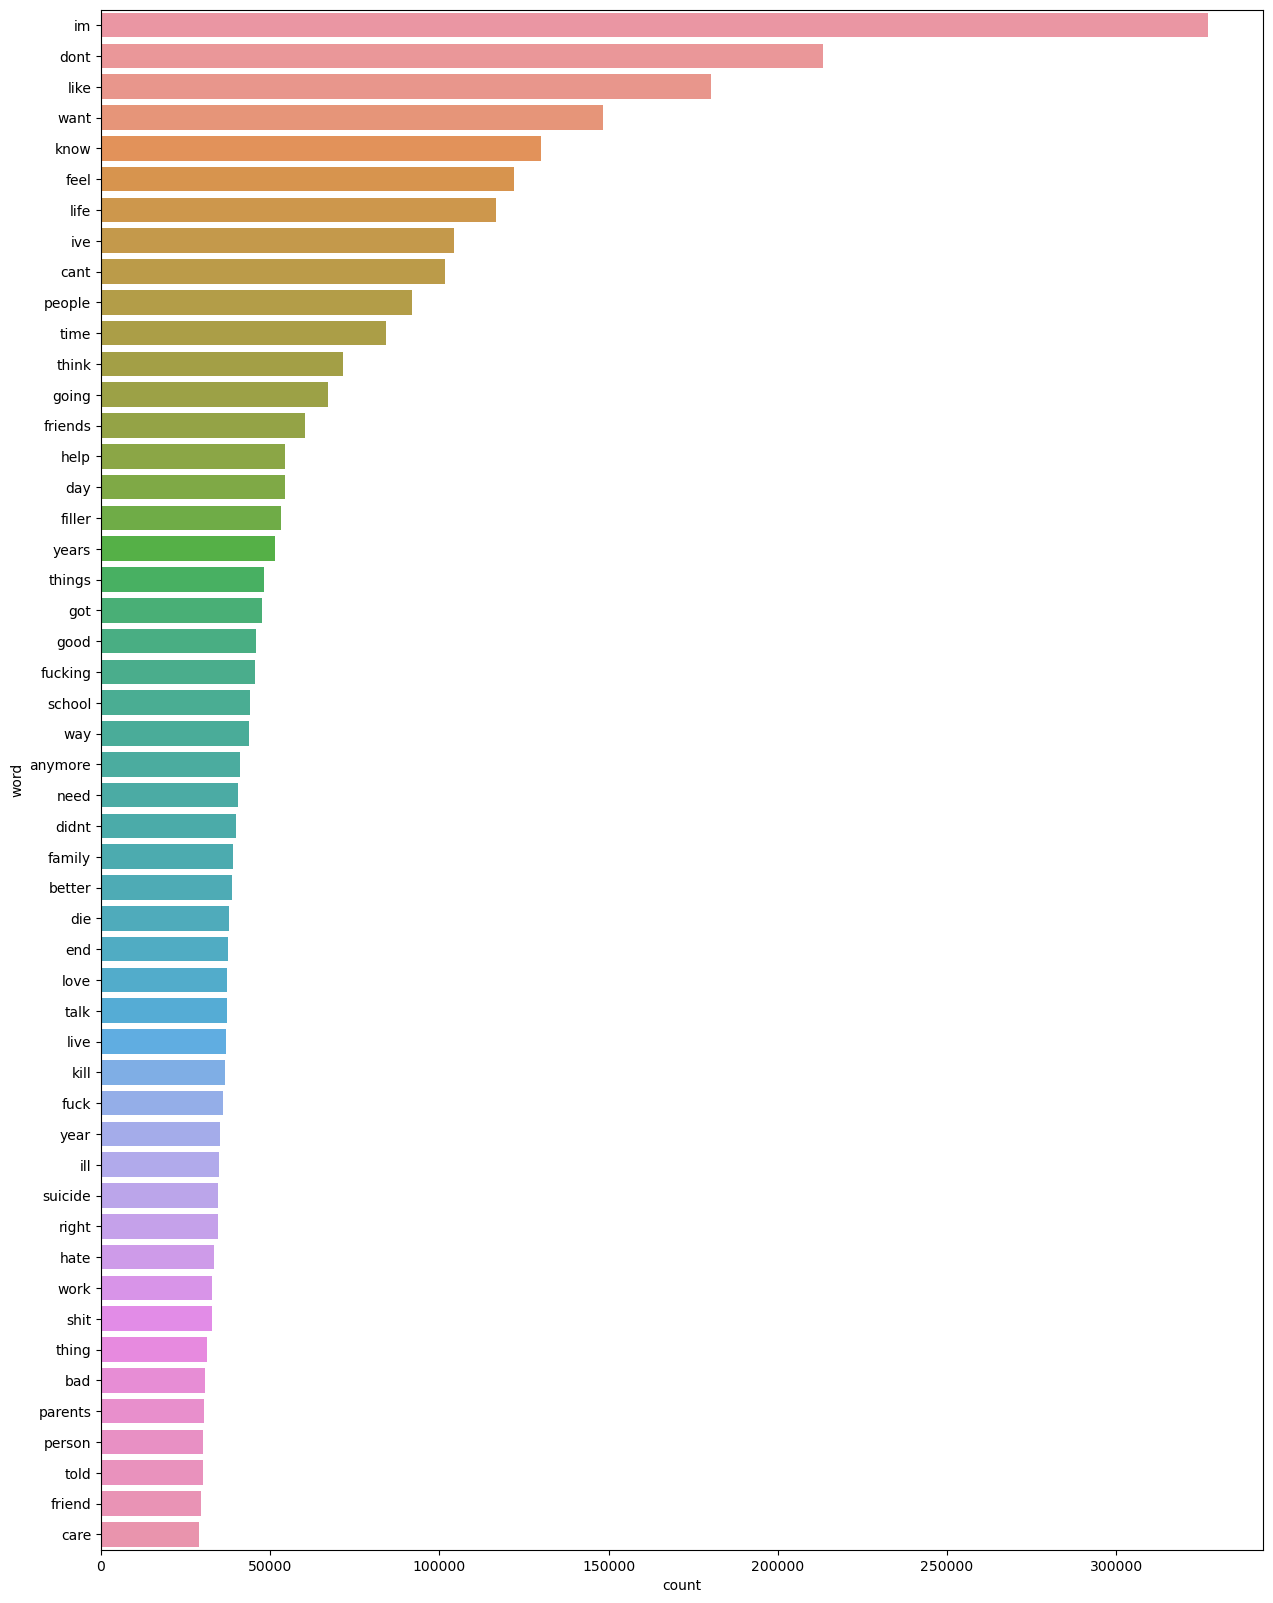

In [36]:
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='count', y='word', data=word_freq.iloc[:50])
plt.show()

In [37]:
train_text_seq = tokenizer.texts_to_sequences(cleaned_train_text)
val_text_seq = tokenizer.texts_to_sequences(cleaned_val_text)
test_text_seq = tokenizer.texts_to_sequences(cleaned_test_text)

In [38]:
# Set the maximum length for each post
max_length = 430

# Pad the sequences to ensure they have the same length
train_text_pad = pad_sequences(train_text_seq, maxlen=max_length)
val_text_pad = pad_sequences(val_text_seq, maxlen=max_length)
test_text_pad = pad_sequences(test_text_seq, maxlen=max_length)

In [39]:
lbl_target = LabelEncoder()
train_output = lbl_target.fit_transform(train_data['class'])
val_output = lbl_target.transform(val_data['class'])
test_output = lbl_target.transform(test_data['class'])

In [40]:
# Build the model
model = Sequential()
model.add(Embedding(30000, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Set the learning rate to 0.0001. Increasing the learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 5
history = model.fit(train_text_pad, train_output, batch_size=batch_size, epochs=epochs,
                    validation_data=(val_text_pad, val_output))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 430, 300)          9000000   
                                                                 
 conv1d_3 (Conv1D)           (None, 426, 128)          192128    
                                                                 
 dropout_1 (Dropout)         (None, 426, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 422, 64)           41024     
                                                                 
 dropout_2 (Dropout)         (None, 422, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 418, 32)           10272     
                                                                 
 dropout_3 (Dropout)         (None, 418, 32)          

In [ ]:
# model = Sequential()
# model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
# model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.2))
# model.add(MaxPooling1D(5))
# model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
# model.add(Dropout(0.4))
# model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
# model.add(Dropout(0.2))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = model.fit(train_text_pad, train_output, epochs=30, batch_size=32, validation_data=(val_text_pad, val_output),
#                     callbacks=[early_stop, reducelr])

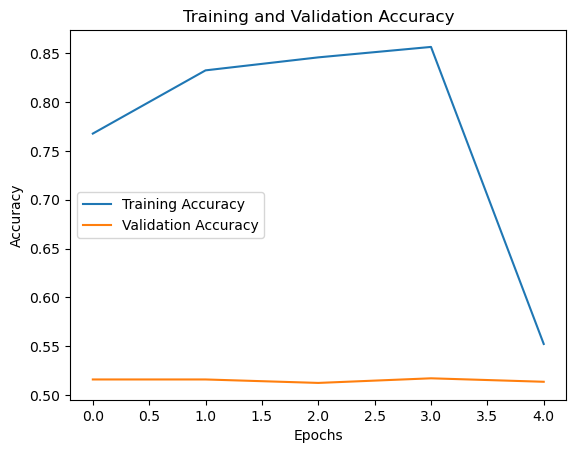

In [41]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

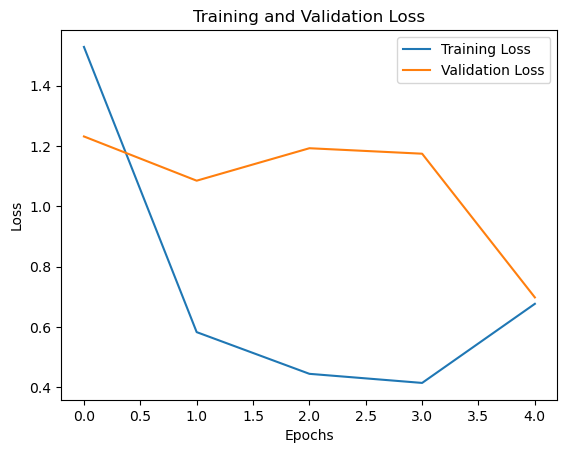

In [42]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


In [43]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_text_pad, test_output, verbose=2)
print('Test Accuracy:', test_acc)

27/27 - 1s - loss: 0.6991 - accuracy: 0.4864 - 547ms/epoch - 20ms/step
Test Accuracy: 0.48642265796661377


In [44]:
# Make predictions on the test set
y_pred = model.predict(test_text_pad)
y_pred = np.round(y_pred).flatten()



27/27 [==============================] - 1s 20ms/step


In [45]:
# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(test_output, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_output, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.65       412
           1       0.00      0.00      0.00       435

    accuracy                           0.49       847
   macro avg       0.24      0.50      0.33       847
weighted avg       0.24      0.49      0.32       847

Confusion Matrix:
[[412   0]
 [435   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# # Combining validation datasets
# cease_val_data = cease_data.sample(frac=0.5, random_state=10)
# cease_test_data = cease_data.drop(cease_val_data.index)

# cease_val_text = cease_val_data['text'].values.tolist()
# cease_val_output = lbl_target.transform(cease_val_data['class'])

# val_text = val_data['text'].values.tolist() + cease_val_text
# val_output = np.concatenate((val_output, cease_val_output))

# val_text_seq = tokenizer.texts_to_sequences(val_text)
# val_text_pad = pad_sequences(val_text_seq, maxlen=max_sequence_length)

# # Combining test datasets
# cease_test_text = cease_test_data['text'].values.tolist()
# cease_test_output = lbl_target.transform(cease_test_data['class'])

# test_text = test_data['text'].values.tolist() + cease_test_text
# test_output = np.concatenate((test_output, cease_test_output))

# test_text_seq = tokenizer.texts_to_sequences(test_text)
# test_text_pad = pad_sequences(test_text_seq, maxlen=max_sequence_length)



In [ ]:
#Redo

In [5]:
# Load the suicide note dataset (source domain)
cease_data = pd.read_csv('/kaggle/input/cares-cease-v20/CARES-CEASE-v2.0 - CARES-CEASE-v2.0.csv')

# Load the Reddit data (target domain)
reddit_data = pd.read_csv('/kaggle/input/suicide-detection/Suicide_Detection.csv')

In [8]:
# Prepare the source domain data (CARES-CEASE-v2.0) and target domain data (Reddit data)
source_text, source_labels = cease_data['text'], cease_data['class']
target_text, target_labels = reddit_data['text'], reddit_data['class']

In [10]:
# Combine the datasets
all_text = np.concatenate((source_text, target_text))
all_labels = np.concatenate((source_labels, target_labels))

In [11]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(all_text)

In [12]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(all_text)

# Set the maximum length for each post
max_length = 500

# Pad the sequences to ensure they have the same length
sequences_pad = pad_sequences(sequences, maxlen=max_length)

In [13]:
# Encode the target labels
lbl_target = LabelEncoder()
labels_enc = lbl_target.fit_transform(all_labels)

In [14]:

# Split the data into source and target domains
source_indices = np.arange(len(source_text))
target_indices = np.arange(len(source_text), len(all_text))

In [15]:
# Define the DANN model
def build_dann_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    embedding_layer = Embedding(len(tokenizer.word_index) + 1, 300, input_length=max_length, trainable=False)(input_layer)
    conv1d_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
    lstm_layer = LSTM(128, return_sequences=True)(conv1d_layer)
    maxpool_layer = GlobalMaxPooling1D()(lstm_layer)
    dense_layer = Dense(64, activation='relu')(maxpool_layer)
    domain_classifier = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=input_layer, outputs=domain_classifier)
    return model

In [16]:
# Build the DANN model
dann_model = build_dann_model((max_length,), 2)  # Assuming binary classification
dann_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Train the DANN model with domain adaptation
batch_size = 64
epochs = 5

In [18]:
# Create domain labels (0 for source, 1 for target)
domain_labels = np.zeros(len(all_text))
domain_labels[target_indices] = 1

In [22]:
# Add the classification layer
num_classes = 2  # Assuming binary classification (0 for non-suicide, 1 for suicide)
classification_layer = Dense(num_classes, activation='softmax', name='classification')(dann_model.layers[-2].output)
adapted_model = Model(inputs=dann_model.input, outputs=classification_layer)

In [23]:
# Compile the adapted model
adapted_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Train the adapted model on the source domain data
source_train_indices = np.arange(len(source_text))
source_test_indices = np.arange(len(source_text))

In [25]:
adapted_model.fit(sequences_pad[source_train_indices], labels_enc[source_train_indices],
                  batch_size=batch_size, epochs=epochs, validation_data=(sequences_pad[source_test_indices], labels_enc[source_test_indices]))

Epoch 1/5
78/78 [==============================] - 6s 39ms/step - loss: 0.5320 - accuracy: 0.8232 - val_loss: 0.4736 - val_accuracy: 0.8283
Epoch 2/5
78/78 [==============================] - 3s 33ms/step - loss: 0.4651 - accuracy: 0.8283 - val_loss: 0.4612 - val_accuracy: 0.8283
Epoch 3/5
78/78 [==============================] - 3s 33ms/step - loss: 0.4605 - accuracy: 0.8283 - val_loss: 0.4597 - val_accuracy: 0.8283
Epoch 4/5
78/78 [==============================] - 3s 32ms/step - loss: 0.4595 - accuracy: 0.8283 - val_loss: 0.4588 - val_accuracy: 0.8283
Epoch 5/5
78/78 [==============================] - 3s 33ms/step - loss: 0.4588 - accuracy: 0.8283 - val_loss: 0.4583 - val_accuracy: 0.8283


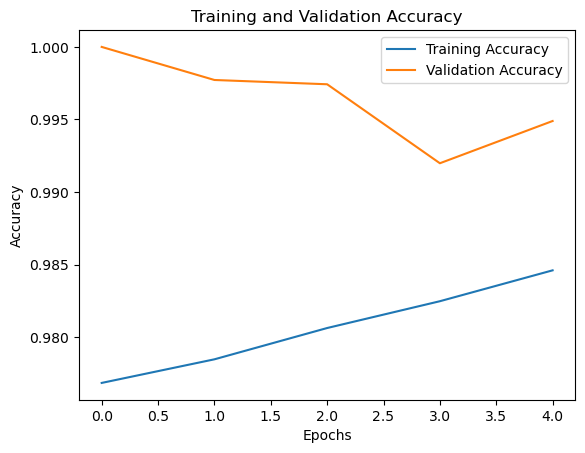

In [30]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

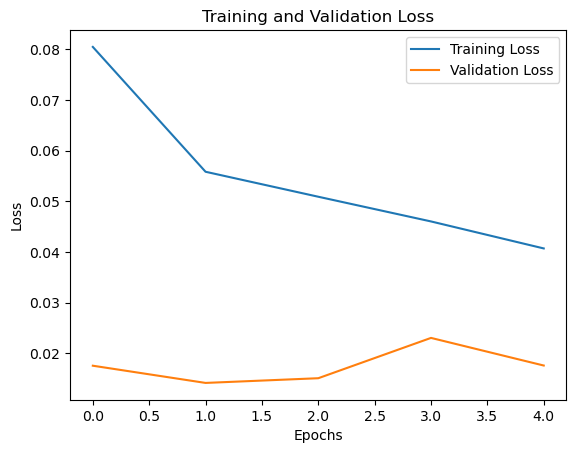

In [31]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [26]:
# Evaluate the adapted model on the target domain data
test_loss, test_acc = adapted_model.evaluate(sequences_pad[target_indices], labels_enc[target_indices], verbose=2)
print('Test Accuracy (Target Domain):', test_acc)

7253/7253 - 94s - loss: 1.0784 - accuracy: 0.5000 - 94s/epoch - 13ms/step
Test Accuracy (Target Domain): 0.5


In [27]:
# Make predictions on the target domain data
target_predictions = adapted_model.predict(sequences_pad[target_indices])
target_predictions = np.argmax(target_predictions, axis=1)

7253/7253 [==============================] - 90s 12ms/step


In [28]:
# Print classification report and confusion matrix for target domain
print("Classification Report (Target Domain):")
print(classification_report(labels_enc[target_indices], target_predictions))

Classification Report (Target Domain):


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    116037
           1       0.50      1.00      0.67    116037

    accuracy                           0.50    232074
   macro avg       0.25      0.50      0.33    232074
weighted avg       0.25      0.50      0.33    232074



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print("Confusion Matrix (Target Domain):")
print(confusion_matrix(labels_enc[target_indices], target_predictions))

Confusion Matrix (Target Domain):
[[     0 116037]
 [     0 116037]]


# Making the Suicide Note the target

In [6]:
# Prepare the source domain data (Reddit data) and target domain data (CARES-CEASE-v2.0)
source_text, source_labels = reddit_data['text'], reddit_data['class']
target_text, target_labels = cease_data['text'], cease_data['class']

In [7]:
# Combine the datasets
all_text = np.concatenate((source_text, target_text))
all_labels = np.concatenate((source_labels, target_labels))

In [8]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(all_text)

In [9]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(all_text)

# Set the maximum length for each post
max_length = 500

# Pad the sequences to ensure they have the same length
sequences_pad = pad_sequences(sequences, maxlen=max_length)

In [10]:
# Encode the target labels
lbl_target = LabelEncoder()
labels_enc = lbl_target.fit_transform(all_labels)

In [11]:
# Split the data into source and target domains
source_indices = np.arange(len(source_text))
target_indices = np.arange(len(source_text), len(all_text))

In [12]:
# Define the DANN model
def build_dann_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    embedding_layer = Embedding(len(tokenizer.word_index) + 1, 300, input_length=max_length, trainable=False)(input_layer)
    conv1d_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
    lstm_layer = LSTM(128, return_sequences=True)(conv1d_layer)
    maxpool_layer = GlobalMaxPooling1D()(lstm_layer)
    dense_layer = Dense(64, activation='relu')(maxpool_layer)
    domain_classifier = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=input_layer, outputs=domain_classifier)
    return model

In [13]:
# Build the DANN model
dann_model = build_dann_model((max_length,), 2)  # Assuming binary classification
dann_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Train the DANN model with domain adaptation
batch_size = 64
epochs = 5

In [15]:
# Create domain labels (0 for source, 1 for target)
domain_labels = np.zeros(len(all_text))
domain_labels[target_indices] = 1

In [16]:
# Train the DANN model with domain adaptation
history = dann_model.fit(sequences_pad, domain_labels,
                         batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
3333/3333 [==============================] - 128s 36ms/step - loss: 0.0081 - accuracy: 0.9997 - val_loss: 2.3072 - val_accuracy: 0.7919
Epoch 2/5
3333/3333 [==============================] - 117s 35ms/step - loss: 6.7202e-06 - accuracy: 1.0000 - val_loss: 2.7781 - val_accuracy: 0.7919
Epoch 3/5
3333/3333 [==============================] - 117s 35ms/step - loss: 9.0199e-07 - accuracy: 1.0000 - val_loss: 3.2118 - val_accuracy: 0.7919
Epoch 4/5
3333/3333 [==============================] - 117s 35ms/step - loss: 1.5905e-07 - accuracy: 1.0000 - val_loss: 3.6109 - val_accuracy: 0.7919
Epoch 5/5
3333/3333 [==============================] - 119s 36ms/step - loss: 3.3340e-08 - accuracy: 1.0000 - val_loss: 3.9701 - val_accuracy: 0.7919


In [17]:
# Freeze the domain classifier part of the model before classification task
dann_model.get_layer('lstm').trainable = False
dann_model.get_layer('conv1d').trainable = False

In [18]:
# Add the classification layer
num_classes = 2  # Assuming binary classification (0 for non-suicide, 1 for suicide)
classification_layer = Dense(num_classes, activation='softmax', name='classification')(dann_model.layers[-2].output)
adapted_model = Model(inputs=dann_model.input, outputs=classification_layer)

In [19]:
# Compile the adapted model
adapted_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train the adapted model on the source domain data
source_train_indices = np.arange(len(source_text))
source_test_indices = np.arange(len(source_text))

adapted_model.fit(sequences_pad[source_train_indices], labels_enc[source_train_indices],
                  batch_size=batch_size, epochs=epochs, validation_data=(sequences_pad[source_test_indices], labels_enc[source_test_indices]))

Epoch 1/5
3627/3627 [==============================] - 121s 33ms/step - loss: 0.6809 - accuracy: 0.5279 - val_loss: 0.6811 - val_accuracy: 0.5369
Epoch 2/5
3627/3627 [==============================] - 144s 40ms/step - loss: 0.6761 - accuracy: 0.5318 - val_loss: 0.6753 - val_accuracy: 0.5372
Epoch 3/5
3627/3627 [==============================] - 143s 40ms/step - loss: 0.6756 - accuracy: 0.5329 - val_loss: 0.6749 - val_accuracy: 0.5374
Epoch 4/5
3627/3627 [==============================] - 143s 40ms/step - loss: 0.6755 - accuracy: 0.5345 - val_loss: 0.6749 - val_accuracy: 0.5377
Epoch 5/5
3627/3627 [==============================] - 143s 40ms/step - loss: 0.6754 - accuracy: 0.5327 - val_loss: 0.6751 - val_accuracy: 0.5372


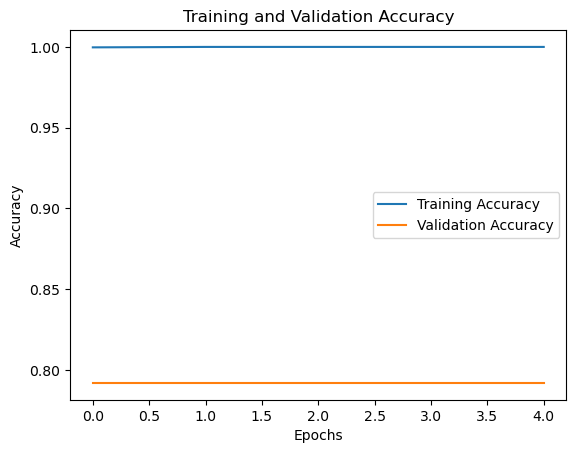

In [23]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

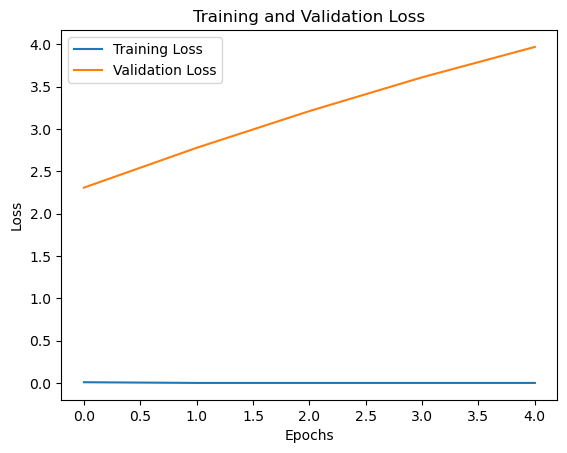

In [24]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [21]:
# Evaluate the adapted model on the target domain data
test_loss, test_acc = adapted_model.evaluate(sequences_pad[target_indices], labels_enc[target_indices], verbose=2)
print('Test Accuracy (Target Domain):', test_acc)

155/155 - 2s - loss: 0.7435 - accuracy: 0.1717 - 2s/epoch - 14ms/step
Test Accuracy (Target Domain): 0.17173559963703156
